# NFL Elimination Picks

In [54]:
import bisect
import collections
import datetime
import random
import heapq
import statistics
import typing

import parsel
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
NUM_TEAMS = 32
NUM_WEEKS = 17

# http://www.espn.com/nfl/schedulegrid
raw_schedule = '''
NFL Schedule Grid
TEAM	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17
ARI	@SF	WSH	DET	@CAR	@NYJ	@DAL	SEA	BYE	MIA	BUF	@SEA	@NE	LAR	@NYG	PHI	SF	@LAR
ATL	SEA	@DAL	CHI	@GB	CAR	@MIN	DET	@CAR	DEN	BYE	@NO	LV	NO	@LAC	TB	@KC	@TB
BAL	CLE	@HOU	KC	@WSH	CIN	@PHI	PIT	BYE	@IND	@NE	TEN	@PIT	DAL	@CLE	JAX	NYG	@CIN
BUF	NYJ	@MIA	LAR	@LV	@TEN	KC	@NYJ	NE	SEA	@ARI	BYE	LAC	@SF	PIT	@DEN	@NE	MIA
CAR	LV	@TB	@LAC	ARI	@ATL	CHI	@NO	ATL	@KC	TB	DET	@MIN	BYE	DEN	@GB	@WSH	NO
CHI	@DET	NYG	@ATL	IND	TB	@CAR	@LAR	NO	@TEN	MIN	BYE	@GB	DET	HOU	@MIN	@JAX	GB
CIN	LAC	@CLE	@PHI	JAX	@BAL	@IND	CLE	TEN	BYE	@PIT	@WSH	NYG	@MIA	DAL	PIT	@HOU	BAL
CLE	@BAL	CIN	WSH	@DAL	IND	@PIT	@CIN	LV	BYE	HOU	PHI	@JAX	@TEN	BAL	@NYG	@NYJ	PIT
DAL	@LAR	ATL	@SEA	CLE	NYG	ARI	@WSH	@PHI	PIT	BYE	@MIN	WSH	@BAL	@CIN	SF	PHI	@NYG
DEN	TEN	@PIT	TB	@NYJ	@NE	MIA	KC	BYE	@ATL	@LV	LAC	NO	@KC	@CAR	BUF	@LAC	LV
DET	CHI	@GB	@ARI	NO	BYE	@JAX	@ATL	IND	@MIN	WSH	@CAR	HOU	@CHI	GB	@TEN	TB	MIN
GB	@MIN	DET	@NO	ATL	BYE	@TB	@HOU	MIN	@SF	JAX	@IND	CHI	PHI	@DET	CAR	TEN	@CHI
HOU	@KC	BAL	@PIT	MIN	JAX	@TEN	GB	BYE	@JAX	@CLE	NE	@DET	IND	@CHI	@IND	CIN	TEN
IND	@JAX	MIN	NYJ	@CHI	@CLE	CIN	BYE	@DET	BAL	@TEN	GB	TEN	@HOU	@LV	HOU	@PIT	JAX
JAX	IND	@TEN	MIA	@CIN	@HOU	DET	BYE	@LAC	HOU	@GB	PIT	CLE	@MIN	TEN	@BAL	CHI	@IND
KC	HOU	@LAC	@BAL	NE	LV	@BUF	@DEN	NYJ	CAR	BYE	@LV	@TB	DEN	@MIA	@NO	ATL	LAC
LV	@CAR	NO	@NE	BUF	@KC	BYE	TB	@CLE	@LAC	DEN	KC	@ATL	@NYJ	IND	LAC	MIA	@DEN
LAR	DAL	@PHI	@BUF	NYG	@WSH	@SF	CHI	@MIA	BYE	SEA	@TB	SF	@ARI	NE	NYJ	@SEA	ARI
LAC	@CIN	KC	CAR	@TB	@NO	NYJ	@MIA	JAX	LV	BYE	@DEN	@BUF	NE	ATL	@LV	DEN	@KC
MIA	@NE	BUF	@JAX	SEA	@SF	@DEN	LAC	LAR	@ARI	NYJ	BYE	@NYJ	CIN	KC	NE	@LV	@BUF
MIN	GB	@IND	TEN	@HOU	@SEA	ATL	BYE	@GB	DET	@CHI	DAL	CAR	JAX	@TB	CHI	@NO	@DET
NE	MIA	@SEA	LV	@KC	DEN	BYE	SF	@BUF	@NYJ	BAL	@HOU	ARI	@LAC	@LAR	@MIA	BUF	NYJ
NO	TB	@LV	GB	@DET	LAC	BYE	CAR	@CHI	@TB	SF	ATL	@DEN	@ATL	@PHI	KC	MIN	@CAR
NYG	PIT	@CHI	SF	@LAR	@DAL	WSH	@PHI	TB	@WSH	PHI	BYE	@CIN	@SEA	ARI	CLE	@BAL	DAL
NYJ	@BUF	SF	@IND	DEN	ARI	@LAC	BUF	@KC	NE	@MIA	BYE	MIA	LV	@SEA	@LAR	CLE	@NE
PHI	@WSH	LAR	CIN	@SF	@PIT	BAL	NYG	DAL	BYE	@NYG	@CLE	SEA	@GB	NO	@ARI	@DAL	WSH
PIT	@NYG	DEN	HOU	@TEN	PHI	CLE	@BAL	BYE	@DAL	CIN	@JAX	BAL	WSH	@BUF	@CIN	IND	@CLE
SF	ARI	@NYJ	@NYG	PHI	MIA	LAR	@NE	@SEA	GB	@NO	BYE	@LAR	BUF	WSH	@DAL	@ARI	SEA
SEA	@ATL	NE	DAL	@MIA	MIN	BYE	@ARI	SF	@BUF	@LAR	ARI	@PHI	NYG	NYJ	@WSH	LAR	@SF
TB	@NO	CAR	@DEN	LAC	@CHI	GB	@LV	@NYG	NO	@CAR	LAR	KC	BYE	MIN	@ATL	@DET	ATL
TEN	@DEN	JAX	@MIN	PIT	BUF	HOU	BYE	@CIN	CHI	IND	@BAL	@IND	CLE	@JAX	DET	@GB	@HOU
WSH	PHI	@ARI	@CLE	BAL	LAR	@NYG	DAL	BYE	NYG	@DET	CIN	@DAL	@PIT	@SF	SEA	CAR	@PHI
'''

class Match(collections.namedtuple("Match", "home away")):
    def __repr__(self):
        return f"<{self.__class__.__name__}: {self.away} @ {self.home}>"
    
# Match("NY", "NJ")

lines = raw_schedule.strip().splitlines()
team_lines = lines[2:]
schedule = {}
games_per_team = collections.Counter()
for tl in team_lines:
    cols = tl.split("\t")
    assert len(cols) == 18
    
    team = cols[0]
    for n_wk, match in enumerate(cols[1:], start=1):
        if match == "BYE":
            continue
        schedule.setdefault(n_wk, [])
        games_per_team[match.strip("@")] += 1
        if match.startswith("@"):
            continue  # skip to avoid double counts
        schedule[n_wk].append(Match(team, match))
    
assert all(n == 16 for n in games_per_team.values())

https://www.espn.com/nfl/fpi

In [3]:
def get_espn_powers():
    data = requests.get("https://www.espn.com/nfl/fpi")
    selector = parsel.Selector(data.text)
    data_table = selector.xpath("//div[@class='Table__Scroller']/table")

    tables = selector.xpath("//div[contains(concat(' ', @class, ' '), ' league-nfl ')]//table")
    assert len(tables) == 2
    name_table, data_table = tables

    club_table = {}
    for club in name_table.xpath("descendant::*[@data-idx]"):
        club_idx = club.xpath("@data-idx").extract_first()
        club_url = club.xpath("descendant::*[@data-clubhouse-uid]/@href")
        url = club_url.extract_first()
        parts = url.split("/")
        assert parts[4] == "name"
        club_table[parts[5].strip().upper()] = int(club_idx)

    assert len(club_table) == NUM_TEAMS

    powers = {}
    for club, idx in club_table.items():
        xq = f"tbody/*[@data-idx='{idx}']"
        r = data_table.xpath(xq)
        cols = r.xpath("td/div/text()")
        pwr = float(cols[1].extract())
        powers[club] = pwr

    assert set(powers) == set(club_table)
    
    return powers

powers = get_espn_powers()

In [4]:
print(datetime.datetime.now().isoformat())
pd.DataFrame(powers.items())

2020-09-20T18:57:32.471132


,0,1
0,BAL,8.0
1,KC,7.5
2,NO,4.8
3,SEA,4.4
4,SF,3.5
5,TB,2.7
6,BUF,2.6
7,PIT,2.5
8,NE,2.5
9,GB,2.4


In [4]:
print(datetime.datetime.now().isoformat())
pd.DataFrame(powers.items())

2020-09-28T16:59:31.690975


,0,1
0,BAL,9.2
1,SF,6.7
2,KC,6.6
3,SEA,4.7
4,GB,4.5
5,LAR,4.4
6,TB,4.2
7,NO,3.9
8,NE,3.5
9,BUF,2.6


In [56]:
powers = get_espn_powers()
print(datetime.datetime.now().isoformat())
pd.DataFrame(powers.items())

2020-10-05T10:13:38.818732


,0,1
0,KC,8.9
1,BAL,7.0
2,SF,5.5
3,SEA,5.1
4,TB,5.0
5,GB,4.4
6,NO,4.3
7,LAR,4.0
8,BUF,3.4
9,NE,2.8


In [57]:
# check schedule names match power names
assert set(powers) == set(games_per_team)

In [58]:
HOME_POWER_BUMP = 3.0

verb_template = "week {wk:2d}: diff {d:+5.1f} - picking {p:3s} ({ps:+3.1f}%PH%) over {vp:3s} ({vps:+3.1f}%VPH%)"


def pick_power_calculator(powers, schedule, picks, home_power=HOME_POWER_BUMP, verbose=False):
    if len(picks) != 17:
        raise ValueError("17 weeks of picks needed")
    if len(set(picks)) != 17:
        raise ValueError("unique picks needed")
    if not all(p in powers for p in picks):
        raise ValueError("unrecognized team initials")
        
    pick_powers = []
    for n_week, pick in zip(sorted(schedule), picks):
        wk_sched = schedule[n_week]
        for match in wk_sched:
            if match.home == pick:
                pick_powers.append(powers[match.home] - powers[match.away] + home_power)
                if verbose:
                    print(verb_template.replace("%PH%", "+H").replace("%VPH%", "  ").format(
                        wk=n_week,
                        d = pick_powers[-1],
                        p=match.home,
                        ps=powers[match.home],
                        vp=match.away,
                        vps=powers[match.away],
                        
                    ))
                break
            if match.away == pick:
                pick_powers.append(powers[match.away] - powers[match.home] - home_power)
                if verbose:
                    print(verb_template.replace("%VPH%", "+H").replace("%PH%", "  ").format(
                        wk=n_week,
                        d = pick_powers[-1],
                        vp=match.home,
                        vps=powers[match.home],
                        p=match.away,
                        ps=powers[match.away],
                        
                    ))
                break
        else:
            raise ValueError(f"team {pick} does not play in week {n_week}")
    return pick_powers       


def pick_grid(powers, schedule, home_bump=HOME_POWER_BUMP):
    matrix = []
    
    index = sorted(powers, key=lambda x: powers[x])
    
    for n_week, matches in sorted(schedule.items()):
        teams = {}
        for match in matches:
            teams[match.home] = powers[match.home] - powers[match.away] + home_bump
            teams[match.away] = powers[match.away] - powers[match.home] - home_bump
        week_col = [teams.get(t, -10) for t in index]
        matrix.append(week_col)
    return index, matrix


In [59]:
random_pick = random.sample(list(powers), k=17)
pick_power_calculator(powers, schedule, random_pick, verbose=True)

week  1: diff -12.8 - picking NYJ (-6.4  ) over BUF (+3.4+H)
week  2: diff  +9.2 - picking TEN (-0.5+H) over JAX (-6.7  )
week  3: diff  -0.3 - picking JAX (-6.7+H) over MIA (-3.4  )
week  4: diff -10.7 - picking PHI (-2.2  ) over SF  (+5.5+H)
week  5: diff  -1.9 - picking IND (+1.3  ) over CLE (+0.2+H)
week  6: diff  +3.6 - picking TB  (+5.0+H) over GB  (+4.4  )
week  7: diff  -8.5 - picking PIT (+1.5  ) over BAL (+7.0+H)
week  8: diff  -2.6 - picking SF  (+5.5  ) over SEA (+5.1+H)
week  9: diff  +6.2 - picking NE  (+2.8  ) over NYJ (-6.4+H)
week 10: diff  -1.9 - picking SEA (+5.1  ) over LAR (+4.0+H)
week 11: diff  +6.3 - picking KC  (+8.9  ) over LV  (-0.4+H)
week 12: diff  -6.5 - picking NYG (-7.6  ) over CIN (-4.1+H)
week 13: diff  +3.7 - picking MIA (-3.4+H) over CIN (-4.1  )
week 14: diff  +4.0 - picking CHI (-1.7+H) over HOU (-2.7  )
week 15: diff  -1.6 - picking NO  (+4.3+H) over KC  (+8.9  )
week 16: diff +17.6 - picking BAL (+7.0+H) over NYG (-7.6  )
week 17: diff  +0.9 - pi

[-12.8,
 9.2,
 -0.30000000000000027,
 -10.7,
 -1.9,
 3.5999999999999996,
 -8.5,
 -2.5999999999999996,
 6.199999999999999,
 -1.9000000000000004,
 6.300000000000001,
 -6.5,
 3.6999999999999997,
 4.0,
 -1.6000000000000005,
 17.6,
 0.8999999999999999]

In [60]:
top_picks = list(powers)[:17]
random.shuffle(top_picks)
pick_power_calculator(powers, schedule, top_picks, verbose=True)

week  1: diff  +2.3 - picking NO  (+4.3+H) over TB  (+5.0  )
week  2: diff  +3.6 - picking IND (+1.3+H) over MIN (+0.7  )
week  3: diff  -2.9 - picking GB  (+4.4  ) over NO  (+4.3+H)
week  4: diff  +5.5 - picking SEA (+5.1  ) over MIA (-3.4+H)
week  5: diff  -7.4 - picking MIN (+0.7  ) over SEA (+5.1+H)
week  6: diff  +5.2 - picking TEN (-0.5+H) over HOU (-2.7  )
week  7: diff  +4.1 - picking DAL (+1.5  ) over WSH (-5.6+H)
week  8: diff +18.3 - picking KC  (+8.9+H) over NYJ (-6.4  )
week  9: diff  +4.1 - picking SF  (+5.5+H) over GB  (+4.4  )
week 10: diff  +4.3 - picking TB  (+5.0  ) over CAR (-2.3+H)
week 11: diff  -6.3 - picking LV  (-0.4+H) over KC  (+8.9  )
week 12: diff  +7.0 - picking NE  (+2.8+H) over ARI (-1.2  )
week 13: diff  +8.5 - picking BAL (+7.0+H) over DAL (+1.5  )
week 14: diff  +4.9 - picking BUF (+3.4+H) over PIT (+1.5  )
week 15: diff  +2.6 - picking PIT (+1.5  ) over CIN (-4.1+H)
week 16: diff  +3.6 - picking CLE (+0.2  ) over NYJ (-6.4+H)
week 17: diff  +8.2 - pi

[2.3,
 3.6,
 -2.8999999999999995,
 5.5,
 -7.3999999999999995,
 5.2,
 4.1,
 18.3,
 4.1,
 4.3,
 -6.300000000000001,
 7.0,
 8.5,
 4.9,
 2.5999999999999996,
 3.6000000000000005,
 8.2]

In [61]:
top_picks = list(powers)[:17]
best_pick = None
best_pick_fitness = -100

def fitness(scores):
    return 100 * min(scores) + sum(scores)

def fitness(scores):
    return 50 * (min(scores) - 3) + sum(scores)

picks = []

HOME_POWER_BUMP = 3.0

for n in range(100_000):
    this_pick = top_picks[:]
    random.shuffle(this_pick)
    try:
        scores = pick_power_calculator(powers, schedule, this_pick)
    except ValueError:
        continue
    
    pick_fitness = fitness(scores)
    
    if pick_fitness < 0:
        continue

    picks.append([min(scores), sum(scores)])
    
    if pick_fitness < best_pick_fitness:
        continue
    
    print("new high score, round {:>9d}, fitness={:+3.1f}".format(n, pick_fitness))
    best_pick = this_pick
    best_scores = scores
    best_pick_fitness = pick_fitness


new high score, round      2836, fitness=+2.1
new high score, round      5179, fitness=+28.0
new high score, round     22516, fitness=+92.9
new high score, round     42174, fitness=+103.5


In [62]:
pick_power_calculator(powers, schedule, best_pick, verbose=True)

week  1: diff  +5.0 - picking IND (+1.3  ) over JAX (-6.7+H)
week  2: diff  +8.9 - picking SF  (+5.5  ) over NYJ (-6.4+H)
week  3: diff  +6.2 - picking NE  (+2.8+H) over LV  (-0.4  )
week  4: diff  +9.6 - picking BAL (+7.0  ) over WSH (-5.6+H)
week  5: diff +12.1 - picking DAL (+1.5+H) over NYG (-7.6  )
week  6: diff  +5.2 - picking TEN (-0.5+H) over HOU (-2.7  )
week  7: diff  +6.8 - picking BUF (+3.4  ) over NYJ (-6.4+H)
week  8: diff  +4.4 - picking LAR (+4.0  ) over MIA (-3.4+H)
week  9: diff  +7.5 - picking MIN (+0.7+H) over DET (-3.8  )
week 10: diff  +5.9 - picking CLE (+0.2+H) over HOU (-2.7  )
week 11: diff  +6.3 - picking KC  (+8.9  ) over LV  (-0.4+H)
week 12: diff  +3.8 - picking NO  (+4.3  ) over DEN (-2.5+H)
week 13: diff  +9.6 - picking GB  (+4.4+H) over PHI (-2.2  )
week 14: diff +14.5 - picking SEA (+5.1+H) over NYJ (-6.4  )
week 15: diff  +2.6 - picking PIT (+1.5  ) over CIN (-4.1+H)
week 16: diff  +6.0 - picking LV  (-0.4+H) over MIA (-3.4  )
week 17: diff  +9.1 - pi

[5.0,
 8.9,
 6.199999999999999,
 9.6,
 12.1,
 5.2,
 6.800000000000001,
 4.4,
 7.5,
 5.9,
 6.300000000000001,
 3.8,
 9.600000000000001,
 14.5,
 2.5999999999999996,
 6.0,
 9.1]

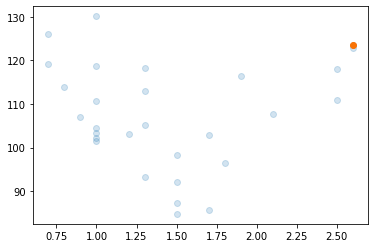

In [63]:
best_scores = pick_power_calculator(powers, schedule, best_pick)
best_point = [min(best_scores), sum(best_scores)]

f, ax = plt.subplots()
ax.scatter(*zip(*picks), alpha=0.2)

ax.scatter(*best_point, color="xkcd:orange")

(<Figure size 576x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe5369c7400>)

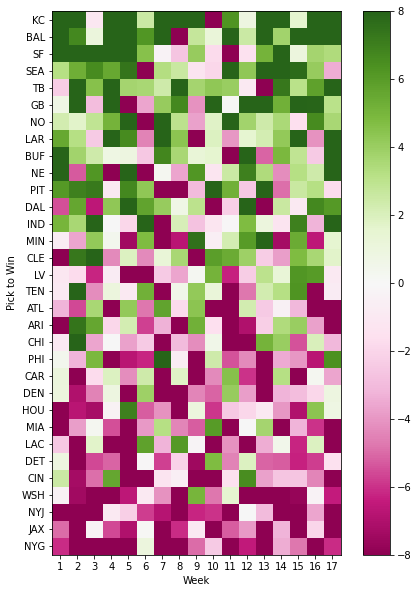

In [64]:
power_rank, matrix = pick_grid(powers, schedule, home_bump=3)

def plot_matrix(matrix, power_rank, cmap="PiYG"):
    f, ax = plt.subplots()
    f.set_size_inches((8, 10))
    imshow = ax.imshow(np.array(matrix).T, vmax=8, vmin=-8, cmap=cmap, origin="lower")
    ax.xaxis.set_ticks(list(range(17)))
    ax.xaxis.set_ticklabels(list(range(1, 18)))
    ax.xaxis.set_label_text("Week")
    ax.yaxis.set_ticks(list(range(32)))
    ax.yaxis.set_ticklabels(power_rank)
    ax.yaxis.set_label_text("Pick to Win")

    f.colorbar(imshow)
    
    return f, ax


plot_matrix(matrix, power_rank)

In [65]:
class PickPermuter:
    def __init__(self, powers, schedule, home_bump=HOME_POWER_BUMP, past_picks=None):
        self.powers = powers
        
        self.schedule = schedule
        self.home_bump = home_bump
        
        self.update_pick_grid()
        
        if past_picks is None:
            self.past_picks = []
        else:
            self.past_picks = list(past_picks)
        
        self.pick = self.greedy()
                
    def update_pick_grid(self):
        self.grid_index, self.grid = pick_grid(self.powers, self.schedule, self.home_bump)

    def __repr__(self):
        score = self.pick_score
#         return "<{}\n {}\n {}\n min={}, avg={}, max={}>".format(
        return "<{}\n {}\n min={}, avg={}, max={}>".format(
            self.__class__.__name__,
            ", ".join(f"{p:>2s}" for p in self.pick),
#             ", ".join(f"{p:>5s}" for p in self.pick),
#             ", ".join(f"{s:>+4.1f}" for s in score),
            min(self.pick_score),
            statistics.mean(self.pick_score),
            max(self.pick_score),
        )
        
    def greedy(self):
        picks = self.past_picks[:]
        for week in self.grid[len(picks):]:
            best_picks = sorted(list(zip(week, self.grid_index)), reverse=True)
            for _score, pick in best_picks:
                if pick not in picks:
                    picks.append(pick)
                    break
            else:
                raise RuntimeError()
        assert len(picks) == len(self.grid) == 17
        return picks
    
    def limited_greedy(self, limit=10):
        picks = self.past_picks[:]
        for week in self.grid[len(picks):]:
            worst_picks = sorted(list(zip(week, self.grid_index)))
            pivot_index = bisect.bisect_left(worst_picks, (limit, "X"))
            order = (worst_picks[pivot_index:] + list(reversed(worst_picks[:pivot_index])))
            for _score, pick in order:
                if pick not in picks:
                    picks.append(pick)
                    break
            else:
                raise RuntimeError()
        assert len(picks) == len(self.grid) == 17
        return picks
    
    def greedy_anneal(self):
        picks = self.greedy()
        
    
    @property
    def pick_score(self):
        return pick_power_calculator(self.powers, self.schedule, self.pick, home_power=self.home_bump)
    
    def describe_pick(self):
        pick_power_calculator(self.powers, self.schedule, self.pick, home_power=self.home_bump, verbose=True)
        
    @property
    def fitness(self):
        return 

In [66]:
my_past_picks = [
    "KC", # week 1
    "TEN", # week 2
    "IND", # week 3
    "LAR", # week 4
]

In [78]:
pp = PickPermuter(powers, schedule, home_bump=3, past_picks=my_past_picks)
pp.describe_pick()

week  1: diff +14.6 - picking KC  (+8.9+H) over HOU (-2.7  )
week  2: diff  +9.2 - picking TEN (-0.5+H) over JAX (-6.7  )
week  3: diff +10.7 - picking IND (+1.3+H) over NYJ (-6.4  )
week  4: diff +14.6 - picking LAR (+4.0+H) over NYG (-7.6  )
week  5: diff +14.1 - picking BAL (+7.0+H) over CIN (-4.1  )
week  6: diff  +5.8 - picking LAC (-3.6+H) over NYJ (-6.4  )
week  7: diff  +9.6 - picking NO  (+4.3+H) over CAR (-2.3  )
week  8: diff  +9.6 - picking TB  (+5.0  ) over NYG (-7.6+H)
week  9: diff  +7.5 - picking MIN (+0.7+H) over DET (-3.8  )
week 10: diff +14.1 - picking GB  (+4.4+H) over JAX (-6.7  )
week 11: diff  +9.3 - picking SEA (+5.1+H) over ARI (-1.2  )
week 12: diff +10.1 - picking DAL (+1.5+H) over WSH (-5.6  )
week 13: diff +10.1 - picking PIT (+1.5+H) over WSH (-5.6  )
week 14: diff +14.1 - picking SF  (+5.5+H) over WSH (-5.6  )
week 15: diff  +6.2 - picking LV  (-0.4+H) over LAC (-3.6  )
week 16: diff  +4.4 - picking HOU (-2.7+H) over CIN (-4.1  )
week 17: diff +12.2 - pi

In [79]:
pplg = PickPermuter(powers, schedule, past_picks=my_past_picks)
pplg.pick = pplg.limited_greedy(limit=8)
pplg.describe_pick()

week  1: diff +14.6 - picking KC  (+8.9+H) over HOU (-2.7  )
week  2: diff  +9.2 - picking TEN (-0.5+H) over JAX (-6.7  )
week  3: diff +10.7 - picking IND (+1.3+H) over NYJ (-6.4  )
week  4: diff +14.6 - picking LAR (+4.0+H) over NYG (-7.6  )
week  5: diff  +8.3 - picking NE  (+2.8+H) over DEN (-2.5  )
week  6: diff  +6.2 - picking BAL (+7.0  ) over PHI (-2.2+H)
week  7: diff  +8.4 - picking PHI (-2.2+H) over NYG (-7.6  )
week  8: diff  +9.6 - picking TB  (+5.0  ) over NYG (-7.6+H)
week  9: diff  +7.5 - picking MIN (+0.7+H) over DET (-3.8  )
week 10: diff  +8.6 - picking PIT (+1.5+H) over CIN (-4.1  )
week 11: diff  +8.4 - picking NO  (+4.3+H) over ATL (-1.1  )
week 12: diff  +9.1 - picking GB  (+4.4+H) over CHI (-1.7  )
week 13: diff +15.7 - picking SEA (+5.1+H) over NYG (-7.6  )
week 14: diff +14.1 - picking SF  (+5.5+H) over WSH (-5.6  )
week 15: diff  +6.2 - picking LV  (-0.4+H) over LAC (-3.6  )
week 16: diff  +6.7 - picking DAL (+1.5+H) over PHI (-2.2  )
week 17: diff  +9.8 - pi

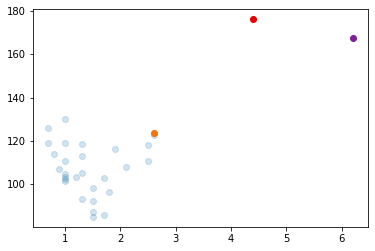

In [80]:
f, ax = plt.subplots()
ax.scatter(*zip(*picks), alpha=0.2)

ax.scatter(*best_point, color="xkcd:orange")

ax.scatter(min(pp.pick_score), sum(pp.pick_score), color="xkcd:red")
ax.scatter(min(pplg.pick_score), sum(pplg.pick_score), color="xkcd:purple")

In [81]:
ppgh3 = PickPermuter(powers, schedule, home_bump=3)
ppgh3.pick = ppgh3.greedy()
ppgh3.describe_pick()

print("-" * 20)

pplgh3 = PickPermuter(powers, schedule, home_bump=3)
pplgh3.pick = pplgh3.limited_greedy(7)
pplgh3.describe_pick()

week  1: diff +14.6 - picking KC  (+8.9+H) over HOU (-2.7  )
week  2: diff +11.2 - picking GB  (+4.4+H) over DET (-3.8  )
week  3: diff +10.7 - picking IND (+1.3+H) over NYJ (-6.4  )
week  4: diff +14.6 - picking LAR (+4.0+H) over NYG (-7.6  )
week  5: diff +14.1 - picking BAL (+7.0+H) over CIN (-4.1  )
week  6: diff  +5.8 - picking LAC (-3.6+H) over NYJ (-6.4  )
week  7: diff  +9.6 - picking NO  (+4.3+H) over CAR (-2.3  )
week  8: diff  +9.6 - picking TB  (+5.0  ) over NYG (-7.6+H)
week  9: diff  +7.5 - picking MIN (+0.7+H) over DET (-3.8  )
week 10: diff  +8.6 - picking PIT (+1.5+H) over CIN (-4.1  )
week 11: diff  +9.3 - picking SEA (+5.1+H) over ARI (-1.2  )
week 12: diff +10.1 - picking DAL (+1.5+H) over WSH (-5.6  )
week 13: diff  +5.1 - picking SF  (+5.5+H) over BUF (+3.4  )
week 14: diff  +4.9 - picking BUF (+3.4+H) over PIT (+1.5  )
week 15: diff  +6.3 - picking TEN (-0.5+H) over DET (-3.8  )
week 16: diff  +6.0 - picking LV  (-0.4+H) over MIA (-3.4  )
week 17: diff +12.2 - pi

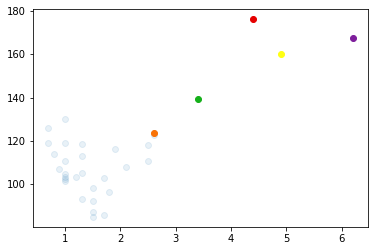

In [82]:
f, ax = plt.subplots()
ax.scatter(*zip(*picks), alpha=0.1)

ax.scatter(*best_point, color="xkcd:orange")

ax.scatter(min(pp.pick_score), sum(pp.pick_score), color="xkcd:red")
ax.scatter(min(pplg.pick_score), sum(pplg.pick_score), color="xkcd:purple")
ax.scatter(min(ppgh3.pick_score), sum(ppgh3.pick_score), color="xkcd:yellow")
ax.scatter(min(pplgh3.pick_score), sum(pplgh3.pick_score), color="xkcd:green")

In [83]:
ppgh1 = PickPermuter(powers, schedule, home_bump=1)
ppgh1.pick = ppgh1.greedy()
ppgh1.describe_pick()

print("-" * 20)

pplgh1 = PickPermuter(powers, schedule, home_bump=1)
pplgh1.pick = pplgh1.limited_greedy(6)
pplgh1.describe_pick()

week  1: diff +12.6 - picking KC  (+8.9+H) over HOU (-2.7  )
week  2: diff +10.9 - picking SF  (+5.5  ) over NYJ (-6.4+H)
week  3: diff  +8.7 - picking IND (+1.3+H) over NYJ (-6.4  )
week  4: diff +12.6 - picking LAR (+4.0+H) over NYG (-7.6  )
week  5: diff +12.1 - picking BAL (+7.0+H) over CIN (-4.1  )
week  6: diff  +3.8 - picking LAC (-3.6+H) over NYJ (-6.4  )
week  7: diff  +8.8 - picking BUF (+3.4  ) over NYJ (-6.4+H)
week  8: diff +11.6 - picking TB  (+5.0  ) over NYG (-7.6+H)
week  9: diff  +8.2 - picking NE  (+2.8  ) over NYJ (-6.4+H)
week 10: diff +12.1 - picking GB  (+4.4+H) over JAX (-6.7  )
week 11: diff  +7.3 - picking SEA (+5.1+H) over ARI (-1.2  )
week 12: diff  +8.1 - picking DAL (+1.5+H) over WSH (-5.6  )
week 13: diff  +8.4 - picking MIN (+0.7+H) over JAX (-6.7  )
week 14: diff  +5.5 - picking NO  (+4.3  ) over PHI (-2.2+H)
week 15: diff  +6.8 - picking CLE (+0.2  ) over NYG (-7.6+H)
week 16: diff  +4.0 - picking LV  (-0.4+H) over MIA (-3.4  )
week 17: diff  +4.4 - pi

In [84]:
ppv = PickPermuter(powers, schedule, home_bump=2.0)

def fitness(scores):
    return min(scores) + statistics.mean(scores) / 2

fits = []
for limiter in np.linspace(4, 10, num=100):
    ppv.pick = ppv.limited_greedy(limiter)
    fits.append((limiter, min(ppv.pick_score), statistics.mean(ppv.pick_score)))

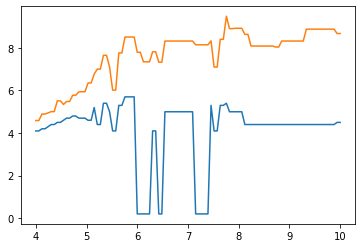

In [85]:
f, ax = plt.subplots()
x, y1, y2 = zip(*fits)
ax.plot(x, y1)
ax.plot(x, y2)

ppv.pick = ppv.greedy()
# ax.plot(10, fitness(ppv.pick_score), "bo")

In [86]:
ppv.describe_pick()

week  1: diff +13.6 - picking KC  (+8.9+H) over HOU (-2.7  )
week  2: diff +10.2 - picking GB  (+4.4+H) over DET (-3.8  )
week  3: diff +11.1 - picking SF  (+5.5  ) over NYG (-7.6+H)
week  4: diff +13.6 - picking LAR (+4.0+H) over NYG (-7.6  )
week  5: diff +13.1 - picking BAL (+7.0+H) over CIN (-4.1  )
week  6: diff  +7.4 - picking IND (+1.3+H) over CIN (-4.1  )
week  7: diff  +8.6 - picking NO  (+4.3+H) over CAR (-2.3  )
week  8: diff +10.6 - picking TB  (+5.0  ) over NYG (-7.6+H)
week  9: diff  +7.2 - picking NE  (+2.8  ) over NYJ (-6.4+H)
week 10: diff  +7.6 - picking PIT (+1.5+H) over CIN (-4.1  )
week 11: diff  +8.3 - picking SEA (+5.1+H) over ARI (-1.2  )
week 12: diff  +9.1 - picking DAL (+1.5+H) over WSH (-5.6  )
week 13: diff  +9.4 - picking MIN (+0.7+H) over JAX (-6.7  )
week 14: diff  +4.4 - picking ARI (-1.2  ) over NYG (-7.6+H)
week 15: diff  +5.8 - picking CLE (+0.2  ) over NYG (-7.6+H)
week 16: diff  +5.0 - picking LV  (-0.4+H) over MIA (-3.4  )
week 17: diff  +8.8 - pi

In [87]:
ppv.pick = ppv.limited_greedy(6.6)
ppv.describe_pick()

week  1: diff  +7.1 - picking PIT (+1.5  ) over NYG (-7.6+H)
week  2: diff  +7.7 - picking BAL (+7.0  ) over HOU (-2.7+H)
week  3: diff  +7.8 - picking CLE (+0.2+H) over WSH (-5.6  )
week  4: diff  +7.5 - picking GB  (+4.4+H) over ATL (-1.1  )
week  5: diff  +7.3 - picking NE  (+2.8+H) over DEN (-2.5  )
week  6: diff  +7.4 - picking IND (+1.3+H) over CIN (-4.1  )
week  7: diff  +7.4 - picking PHI (-2.2+H) over NYG (-7.6  )
week  8: diff +10.6 - picking TB  (+5.0  ) over NYG (-7.6+H)
week  9: diff +13.2 - picking KC  (+8.9+H) over CAR (-2.3  )
week 10: diff  +5.0 - picking MIA (-3.4+H) over NYJ (-6.4  )
week 11: diff  +7.4 - picking NO  (+4.3+H) over ATL (-1.1  )
week 12: diff  +9.0 - picking BUF (+3.4+H) over LAC (-3.6  )
week 13: diff  +9.4 - picking MIN (+0.7+H) over JAX (-6.7  )
week 14: diff +13.1 - picking SF  (+5.5+H) over WSH (-5.6  )
week 15: diff  +8.7 - picking SEA (+5.1  ) over WSH (-5.6+H)
week 16: diff  +5.7 - picking DAL (+1.5+H) over PHI (-2.2  )
week 17: diff  +7.2 - pi

In [88]:
ppv.pick = ppv.limited_greedy(9)
ppv.describe_pick()

week  1: diff +11.8 - picking BUF (+3.4+H) over NYJ (-6.4  )
week  2: diff  +9.3 - picking TB  (+5.0+H) over CAR (-2.3  )
week  3: diff  +9.7 - picking IND (+1.3+H) over NYJ (-6.4  )
week  4: diff  +9.7 - picking SF  (+5.5+H) over PHI (-2.2  )
week  5: diff  +9.9 - picking NO  (+4.3+H) over LAC (-3.6  )
week  6: diff  +7.2 - picking BAL (+7.0  ) over PHI (-2.2+H)
week  7: diff  +9.4 - picking KC  (+8.9  ) over DEN (-2.5+H)
week  8: diff  +5.7 - picking GB  (+4.4+H) over MIN (+0.7  )
week  9: diff  +7.2 - picking NE  (+2.8  ) over NYJ (-6.4+H)
week 10: diff  +7.6 - picking PIT (+1.5+H) over CIN (-4.1  )
week 11: diff  +8.3 - picking SEA (+5.1+H) over ARI (-1.2  )
week 12: diff  +9.1 - picking DAL (+1.5+H) over WSH (-5.6  )
week 13: diff  +9.4 - picking MIN (+0.7+H) over JAX (-6.7  )
week 14: diff  +4.4 - picking ARI (-1.2  ) over NYG (-7.6+H)
week 15: diff +12.4 - picking LAR (+4.0+H) over NYJ (-6.4  )
week 16: diff  +5.0 - picking LV  (-0.4+H) over MIA (-3.4  )
week 17: diff  +5.4 - pi